In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from gradient_descent import gradient_descent, minibatch_class
import utils
from utils import Poisson_reg
from utils import sample_PLN

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from timeit import default_timer as timer
from tqdm import tqdm 
import time 
import sys 
import matplotlib as mpl
from cycler import cycler
plt.style.use('ggplot')

from __future__ import print_function
import psutil
import multiprocessing
import concurrent.futures
import threading

import numpy as np
import seaborn as sns 
import torch
from torch import nn
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
torch.set_default_dtype(torch.float64)

In [3]:
class PLN_full():
    def __init__(self, C_init, beta_init, M_init, S_init, class_optimizer = torch.optim.Adam, requires_tridiag = True): 
        '''
            Initialization : 
            'Y' : the data, size (n,p). n is the number of samples we have and p the number of species. 
                  the entries should be int but dtype = float. 
            'O': offset : additional offset. (not very important for comprehension). size (n,p)
            'covariates' : covariates, size (n,d)
            'C_init' : initialization for C. I plan to do a more advanced initialization. 
            'beta_init ' : Initialization for beta. I plan to do a more advanced initialization. 
            'M_init' : initialization for the variational parameter M
            'S_init ': initialization for the variational parameter S
            'requires_tridiag' : bool. If True, the parameters C wil be a vector 
                                of size (n(n+1)/2). It will form a lower tridiagonal matrix after,
                                but we encode it as a vector for pytorch. Advantages : we get about half less 
                                parameter if True. 
                                If False, C will be a Matrix of size (n,n). It won't be a lower tridiagonal Matrix
                                after some gradient steps. 
        '''
        # model parameters
        # we start with the initialization of C, that is the most subtle. If you want tridiagonals matrices 
        # at every iteration then the parameters C of the optimizer will be a vector ( we will change this vector 
        # into a matrix at each iteration to compute the loss. It is more convenient this way. 
        #Else, it will be a matrix

        
        if requires_tridiag : 
            self.C = torch.clone(mat2vec_lower_tridiag(C_init))
            self.requires_tridiag = True 
        else : 
            self.C = torch.clone(C_init) 
            self.requires_tridiag = False 
            
        self.C.requires_grad_(True)
        self.Sigma = torch.clone(torch.mm(C_init,C_init.T))
        self.Sigma.requires_grad_(False) # we don't need to have a gradient for Sigma since we will 
                                         # always update it with a closed form (since we have constraints
                                         # of positivity and symmetry)
        #note that C and sigma have a similr role here. We will use either C or Sigma 
        #depending on the loss we choose. 
        
        self.beta = torch.clone(beta_init)
        self.beta.requires_grad_(True)
        
        #variational parameters
        self.M = torch.clone(M_init)
        self.M.requires_grad_(True)
        self.S = torch.clone(S_init) 
        self.S.requires_grad_(True)
        
        
        self.params = {'S' : self.S,'M' : self.M,'C' : self.C, 'beta' : self.beta, 'Sigma' : self.Sigma}
        
        self.old_loss = 1
        
        self.class_optimizer = class_optimizer
        
        # some lists to store some stats
        self.t0 = time.time()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.ELBO_list = list()
        self.running_times = list()

        
    def extract_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. 
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0];self.O = data[1];self.covariates = data[2]
        self.n, self.p = self.Y.shape
        
        
        
    ###################### parametrisation centered in X@\beta, variance CC.T ##############
    
    
    
    def compute_ELBO(self): 
        '''
        compute the ELBO with the parameter of the model we have extract. 
        This ELBO uses the parametrization for Z ~ N(XB,Sigma)
        '''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_tridiag(self): 
        '''
        same function as above, but the parameter C is a vector here. 
        it does the same but changes C from a vector to a lower tridiagonal Matrix. 
        '''
        return ELBO_tridiag(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_Sigma(self): 
        '''
        Computes the ELBO when Sigma is the parameter, (in opposition to C)
        '''
        return ELBO_Sigma(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    
    
    
    ####################### parametrisation centered in 0, variance Sigma  ################
    
    
    
    
    
    def compute_first_ELBO(self):
        '''
        compute the ELBO of the first notebook, i.e. another parametrisation 
        '''
        return first_ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    def compute_profile_ELBO(self): 
        '''
        compute the ELBO from the profiled formula. 
        '''
        self.Sigma = first_closed_Sigma(self.M,self.S) # we update Sigma 
        gain = profile_ELBO(self.Y,self.O,self.covariates,self.M,self.S, self.Sigma,self.beta)
        return gain
    
    
    ##################### parametrisation centered in 0 and unit variance ##################
    
    
    
    
    def compute_ELBO_PCA(self): 
        '''
        compute the ELBO from the PCA parametrization.
        '''
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_PCA_tridiag(self): 
        '''
        compute the ELBO when C is a vector that encodes a tridiagonal Matrix from the PCA parametrisation
        '''
        matC = vec2mat_lower_tridiag(self.C)
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,matC ,self.beta)
    
    

    
    
    # gradient ascent function, core function of the class. 
    def torch_gradient_ascent(self, optimizer, compute_gain,params, tolerance , N_epoch ,  requires_closed_Sigma, verbose): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 

        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 

                'compute_gain' : function. It should call the parameters by itself. i.e. we wil 
                                all compute_gain() without any parameter in argument. 

                       
                'tolerance': float. the threshold we set to stop the algorithm. It will 
                              stop  if we are not improving the loss more than tolerance. 
                              
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                
                'requires_closed_Sigma' : bool. tells if we are using Sigma (True) or C(False). 
                                          Here just to keep track of the error.
                                          between self.Sigma and true_Sigma

                'Verbose' : bool. if True, will print some messages useful to 
                            interpret the gradient ascent. If False, nothing will be printed. 
 
        returns : None 
        '''
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5,patience = 3)
        # we set the gradient to zero just to make sure the gradients are properly calculated
        optimizer.zero_grad()

        stop_condition = False 
        i = 0

        while i < N_epoch and stop_condition == False: 
            optimizer.zero_grad()
            loss = -compute_gain()
            loss.backward()
            #print('sanity check : ', torch.norm(params['beta'].grad+grad_beta(data[0], data[1],data[2] ,params['M'] ,params['S'] ,params['C'] ,params['beta']) ))
            if torch.isnan(loss).item() == True : 
                print('NAN')
            optimizer.step()
            
            delta = self.old_loss - loss.item() 
            '''
            if delta < 0 : 
                print('We regressed of ', delta )
            else : 
                print('We gain ', delta )
            '''
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            
            self.old_loss = loss.item()
            
            # keep track of the error with Sigma. 
            if requires_closed_Sigma : # if we use Sigma as parameter 
                self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            else : #if we use C 
                if len(params['C'].shape) > 1 : # C is a matrix ( requires_tridiag = False)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(self.C,self.C.T)-true_Sigma)**2).item())
                else : # C is a vector (requires_tridiag = true)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(vec2mat_lower_tridiag(self.C),
                                                           vec2mat_lower_tridiag(self.C).T)-true_Sigma)**2).item())

            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.ELBO_list.append(-loss.item())
            # print some stats if we want to
            if i%200 == 0 and verbose : 
                print('iteration number: ', i)
                print('-------UPDATE-------')
                print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
                print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
                print('ELBO : ', np.round(-loss.item(),5))
                print('Delta : ', delta)
                if i % 500 == 21 : 
                    sns.heatmap(self.Sigma)
                    plt.show()
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)

        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch, 'last delta = ', delta)
 
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
        
    
    ### we will build all the algorithms based on the previous function. The function will 
    ### basically be the same, we will change the gain considered (depends on the parametrisation we take 
    ### mainly). We will also update the parameters if we have closed form. 
    
    
    
    
    ####### parametrisation centered in 0 and unit variance #########
    
    
    
    def full_grad_ascent_PCA(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta) with the loss from the PCA
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C, self.beta], lr = lr)
        
        # we extract the data
        self.extract_data(data)
        
        #we choose the right loss. Note that both loss uses C and not Sigma. 
        #if we have chosen a tridiagonal matrix : 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_PCA_tridiag
        else : # if we have not chosen a tridiagonal matrix,
            gain = self.compute_ELBO_PCA
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, gain,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= False,verbose = verbose)
        
        
        
        
    ########## parametrisation centered in X@\beta, variance C.C.T ###########
    
    
    
    
    
    def full_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta)
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C, self.beta], lr = lr)
        
        # we extract the data
        self.extract_data(data)
        
        #we choose the right loss. Note that both loss uses C and not Sigma. 
        #if we have chosen a tridiagonal matrix : 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : # if we have not chosen a tridiagonal matrix,
            gain = self.compute_ELBO
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, gain,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= False,verbose = verbose)
        
    def VEM_beta_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.03, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update beta with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,C)
        for N_epoch_max iteration and then update beta.
        args : same as above. 
        '''
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C], lr = lr)
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        # choose the right loss. Note that the loss uses C here. 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : 
            gain = self.compute_ELBO
            
        for i in range(Number_VEM_step): 
            #gradient ascent for N_epoch_max iteration maximum. 
            self.torch_gradient_ascent(self.optimizer, gain ,self.params, 
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= False, verbose = verbose)
            if verbose : 
                print(' i : ', i )
            #update beta
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
            if verbose and i %50 == 0 : 
                print('beta closed')
                sns.heatmap(self.Sigma)
                plt.show()
            
        
        
        
    ########## parametrisation centered in X@\beta and variance Sigma ###############
    
    
    
    def profile_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True):
        
        '''
        gradient ascent with the profiled formula. We replace Sigma by the argmax in some part 
        to avoid computing the inverse of Sigma. 
        args : same as above     
        '''
        self.extract_data(data)
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        # we first do one simple gradient ascent to avoid computing the log of zero. (does not work very well yet)
        self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = 0 , N_epoch = 20 ,
                requires_closed_Sigma= True, verbose = verbose)
        
        self.torch_gradient_ascent(self.optimizer, self.compute_profile_ELBO,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= True,verbose = verbose)
    
    def VEM_both_closed(self,data,Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True ): 
        '''
        VEM where we use the closed form both of Sigma and beta. As a result, 
        the M-step is straightforward as we only choose update beta and sigma once. 
        The VE-step uses optimization.
        
        args : same as above except : 
              -'tolerance' : float. Threshold 
              that tells when to stop. If the gain have not improved 
              of more than tolerance, then we stop the VE step. 
              The tolerance of the first step will start at tolerance, 
              but will be decreased at each iteration at a factor of 1/i. 
              -'Number_VEM_step' int. The number of times we will do a VE and a M step.   
        '''
        self.take_C = False
        
        self.optimizer = self.class_optimizer([self.S,self.M], lr = lr)
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        for i in range(Number_VEM_step): 
            # VE step. We choose the gain that uses Sigma and not C. 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params, 
                            tolerance = tolerance/(i+1),N_epoch = N_epoch_max,
                            requires_closed_Sigma= True, verbose = verbose)
            #M_step 
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            if verbose and i %50 == 0 : 
                print('both closed')
                sns.heatmap(self.Sigma)
                plt.show()

            
    def VEM_Sigma_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update Sigma with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.take_C = False
        
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        self.extract_data(data)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= True, verbose = verbose)
            with torch.no_grad():
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            if verbose and i %50 == 0 : 
                print('Sigma closed')
                sns.heatmap(self.Sigma)
                plt.show()
                
                
           
    ########## parametrisation centered 0 and variance Sigma ###############
                
    
                
    def first_VEM(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ): 
        '''
        VEM where we update Sigma with its closed form.
        each N_epoch_max iteration.  We use another parametrisation, the one in PLN_test.ipynb. 
        This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        self.extract_data(data)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= True, verbose = verbose)
            with torch.no_grad():
                self.Sigma = 1/self.n*(torch.mm(self.M.T,self.M) + torch.diag(torch.sum(torch.multiply(self.S,self.S), dim = 0)))
                
                
    def get_Sigma(self): 
        if self.take_C : 
            try  :mat_C = vec2mat_lower_tridiag(self.C)
            except : mat_C = torch.clone(self.C)
            return (mat_C @ (mat_C.T)).detach().numpy()
        else : 
            return self.Sigma.detach().numpy()

In [32]:
def print_stats(loss, params, optimizer): 
    '''
    small function that print some stats. 

    It will print the actual learning rate of the optimizer, the actual log likelihood 
    and the norms of each parameter's gradient. The norm of the parameter's gradient should be low
    when we are close to the optimum. 
    '''
    print('---------------------------------lr :', optimizer.param_groups[0]['lr'])
    print('---------------------------------log likelihood :', - loss.item())
    for param_name, param in params.items(): 
        try :
            with torch.no_grad : # to avoid Warnings 
                print('---------------------------------grad_{}_norm : '.format(param_name), round(torch.norm(param.grad).item(), 3))
        except : 
            pass 




# Here are the gradients with the parametrisation centered in X\beta and variance C@C.T above. 
def grad_beta(Y, O, covariates ,M ,S ,C ,beta) : 
    grad = torch.mm(torch.mm(covariates.T, M-torch.mm(covariates, beta) ), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_M(Y, O, covariates ,M ,S ,C ,beta):
    grad = Y - torch.exp(O+M+torch.multiply(S,S)/2)-torch.mm(M-torch.mm(covariates,beta), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_S(Y, O, covariates ,M ,S ,C ,beta): 
    return torch.div(1,S)-torch.multiply(S, torch.exp(O+M+torch.multiply(S,S)/2))-torch.mm(S, torch.diag(torch.diag(torch.inverse(torch.mm(C,C.T)))))

def grad_C(Y, O, covariates ,M ,S ,C ,beta): 
    n = Y.shape[0]
    CCT = torch.mm(C,C.T)
    MmoinsXB = M-torch.mm(covariates, beta) 
    big_mat = torch.diag(torch.sum(torch.multiply(S,S), dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    return torch.mm(torch.mm(torch.inverse(C),(big_mat +big_mat.T)/2.),torch.inverse(CCT)).T - Y.shape[0]*torch.inverse(C).T

def grad_Sigma(Y, O, covariates ,M ,S ,Sigma ,beta): 
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    MmoinsXB = M-torch.mm(covariates,beta)
    grad = -n/2*(inv_Sigma)
    grad += 1/2*torch.mm(torch.mm(inv_Sigma,torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))), inv_Sigma)
    return grad
    
    grad += 1/2*(sum([inv_Sigma@(torch.outer(MmoinsXB[i,:],MmoinsXB[i,:])+ torch.diag(torch.multiply(S,S)[i,:]))@inv_Sigma 
                      for i in range(n)]))
    return grad

def closed_Sigma(M,S,covariates,beta):
    '''
    closed form for Sigma with the first parametrisation centered in X\beta and variance Sigma 
    '''
    n,p = M.shape
    MmoinsXB = M-torch.mm(covariates,beta)
    return 1/(n)*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0)))

    
def first_closed_Sigma(M,S): 
    '''
    closed form for Sigma with the parametrisation of the first notebook
    '''
    n = M.shape[0]
    return 1/n*(torch.mm(M.T,M) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))) 
                          
def closed_beta(X,M): # the X is the covariates. 
    '''
    closed form for beta with the first parametrisation above
    '''
    return torch.mm(torch.mm(torch.inverse(torch.mm(X.T,X)), X.T),M)


###### parametrisation centered in X@beta and variance C@C.T ######



def ELBO(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO of the parameters. We use the formula below. (J_{\theta,q})
    '''
    n = Y.shape[0]
    #store some matrices to avoid compute it many times. 
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    #formula below 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(torch.mm(C,C.T)), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n*torch.log(torch.det(C))
    return tmp 

def ELBO_tridiag(Y, O,covariates ,M ,S ,vectC ,beta):
    '''
    Same as ELBO, but the parameter C in argument is a vector. 
    We only need to covert it to a matrix and then compute the ELBO with this matrix.
    '''
    matC = vec2mat_lower_tridiag(vectC)
    return ELBO(Y, O,covariates ,M ,S ,matC ,beta)



########## parametrisation centered in X@beta and variance Sigma #########



def ELBO_Sigma(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''
    Same as ELBO but the parameter is not C but Sigma. basically, we will replace 
    CC.T by Sigma 
    '''
    n = Y.shape[0]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    tmp_bis =- n/2*torch.log(torch.det(Sigma))
    
    tmp_bis += torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp_bis -= n*p/2
    return tmp


######## Parametrisation centered in 0 and unit variance #########




def ELBO_PCA(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO from the PCA parametrisation. 
    '''
    #take C or C.T?
    A = O + torch.mm(covariates,beta)+torch.mm(M,C.T)
    SrondS = torch.multiply(S,S)
    J = torch.sum(torch.multiply(Y,A)-torch.exp(A + 1/2*torch.mm(SrondS,torch.multiply(C,C).T))
                  +1/2*torch.log(SrondS)-1/2*(torch.multiply(M,M)+torch.multiply(S,S)))
    return J 




####### parametrisation centered in 0 and Variance Sigma ##########




def first_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    ''' 
    computes the ELBO. We simply apply the formula given above. 
    '''
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    tmp = -n/2*torch.log(torch.det(Sigma)) #-1/2*( torch.sum(torch.mm(torch.mm(M,inv_Sigma),M.T).diagonal()))
    tmp += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    tmp -= 1/2*torch.trace(torch.mm(torch.mm(M.T, M) + torch.diag(torch.sum(SrondS, dim = 0)), inv_Sigma))
    tmp += 1/2*torch.sum(torch.log(SrondS))
    return tmp

def profile_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    '''
    computes the profiled ELBO. We replaced Sigma with its closed form to 
    avoid computing the inverse of Sigma. Should be faster, but does not work very well in practice. 
    Indeed, we have some nan values that appears for large values of p. 
    '''
    n = Y.shape[0]
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    J = -n/2*torch.log(torch.det(Sigma))
    J  += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    J-= n*p/2
    J += 1/2*torch.sum(torch.log(SrondS))
    return J 




#ELBO(Y_sampled,0,covariates,M_init,S_init,C_init,beta_init)
#some sanity checks to see if we have the right closed forms. Those quantities should be zero. 
#print(grad_Sigma(Y_sampled, O, covariates, M_init,S_init, closed_Sigma(M_init,S_init, covariates,beta_init), beta_init))
#print(grad_beta(Y_sampled, O, covariates, M_init,S_init, C_init, closed_beta(covariates,M_init)))


In [36]:
def launch_optimizers(dict_optimizers):
    ts = list()
    N_iter = 400
    lr = 0.001
    models = list()
    Nb_each_iter = 20 
    for name, optimizer in dict_optimizers.items(): 
        model = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = optimizer)
        #t = threading.Thread(target =model.full_grad_ascent,
        #      args = [data, N_iter*8           ,3*lr     , False] )
        t = threading.Thread(target =model.VEM_both_closed,
              args = [data, N_iter           ,Nb_each_iter      , lr,  0.1 , False] )
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
        
    return dict(zip(dict_optimizers.keys(), models))

def launch_models(class_optim,N_iter, lr ): 
    model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim, requires_tridiag = False)
    model_VEM_Sigma = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim) # we do not care of requires_tridiag since we use Sigma 
    model_VEM_both = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    model_full = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    model_PCA = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    model_first = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    model_profile = PLN_full(C_init, beta_init, M_init, S_init, class_optimizer = class_optim)
    Nb_each_iter = 20
    t_beta = threading.Thread(target =model_VEM_beta.VEM_beta_closed, 
              args = [data, N_iter           ,Nb_each_iter            ,lr            , 0.1, False] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_Sigma = threading.Thread(target =model_VEM_Sigma.VEM_Sigma_closed,
              args = [data, N_iter           ,Nb_each_iter     ,lr, 0.1             , False] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_both = threading.Thread(target =model_VEM_both.VEM_both_closed,
              args = [data, N_iter           ,Nb_each_iter      , lr,  0.1 , False] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_full = threading.Thread(target =model_full.full_grad_ascent,
              args = [data, N_iter*8           ,3*lr     , True] )
                     #data, N_epoch = 1000, lr = 0.03,  verbose = True ): 

    t_PCA = threading.Thread(target =model_PCA.full_grad_ascent_PCA, 
             args = [data,  N_iter*8,   3*lr,              False])
    t_first =  threading.Thread(target =model_first.first_VEM,
              args = [data, N_iter           ,Nb_each_iter              ,lr     , 0.1             , False] )

    t_profile = threading.Thread(target = model_profile.profile_grad_ascent, 
                        args =[data, N_iter*13, 3*lr, False ] )

    t0 = time.time()

    t_beta.start()
    t_Sigma.start()
    t_both.start()
    t_full.start()
    t_PCA.start()
    #t_first.start()
    #t_profile.start()

    t_beta.join()
    t_Sigma.join()
    t_both.join()
    t_full.join()
    t_PCA.join()
    #t_profile.join()
    #t_first.join()
    print('Execution time : ', time.time()-t0)

    dict_models = {'closed_beta' : model_VEM_beta,'closed_Sigma' : model_VEM_Sigma, 
              'both_closed' :model_VEM_both, 'full' : model_full, 
                   'profiled' : model_profile}#'PCA_formula': model_PCA,
    return dict_models

def compare_models(dict_models):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the ELBO in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model.
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(3,1,figsize = (15,12))
    
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        ax[0].set_ybound( lower=0, upper=0.7)
        ax[0].set_title('MSE Sigma')
        ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('MSE')
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('MSE')
        length = len(abscisse)
        
        keep = 0.7 # to keep the best ones 
        ax[2].plot(abscisse[-int(length*keep):], model.ELBO_list[-int(length*keep):], label = name )
        ax[2].legend()
        ax[2].set_title('ELBO')
        ax[2].set_ylabel('ELBO')
        ax[2].set_xlabel('Seconds')
        
    plt.savefig('Comparison models.jpeg')
    plt.show()
    
def show_Sigma(dict_model): 

    for name,model in dict_model.items():
        print('model : ', name)
        try : 
            sns.heatmap(model.get_Sigma()- true_Sigma.numpy())
            plt.show()
            print(' MSE : ', np.mean((model.get_Sigma()- true_Sigma.numpy())**2))
        except : pass 
    print('true Sigma : ', sns.heatmap(true_Sigma.numpy()))

$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+C M) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{(C\odot C)   (S \odot S)}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$

In [5]:
def vec2mat_lower_tridiag(vectC): 
    '''
    transform a vector of size (n(n+1)/2) into a lower tridiagonal matrix of size (n,n). 
    
    args : 'vectC' vector of size (n*(n+1)/2)
    
    returns 'matC' : matrice of size(n,n). Its lower tridiagonal will be computed from 
            vectC as follows : 
            for all i < n : - matC[i,i] = out[i*(i+1)/2]
                            - matC[i+1, 0] = out[i*(i+1)/2 + 1]
            matC[n,n] = out[n*(n+1)/2] 
            
            see torch.tril_indices for more 
            
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    '''
    somme_entiers = vectC.shape[0]
    n = int((-1+math.sqrt(1+8*somme_entiers))/2)
    mask = torch.tril_indices(n,n).unbind()
    matC = torch.zeros((n,n))#, dtype = torch.float)
    matC[mask] = vectC
    return matC

def mat2vec_lower_tridiag(matC): 
    '''
    extract the lower tridiagonal of a matrice. returns a vector. 
    
    args : 'matC' : A squared matrices of float. 
    
    returns : a vector of size(n*(n+1)/2) where n is the first (or second) size of matC. 
              It is computed as the following : 
              for all i < n : -out[i*(i+1)/2] = matC[i,i]
                              -out[i*(i+1)/2 + 1] = matC[i+1, 0]
              out[n*(n+1)/2] = matC[n,n]
              
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    
    see torch.tril_indices for more 
    '''
    n = matC.shape[0]
    mask = torch.tril_indices(n,n).unbind()
    return matC[mask]

def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    
    torch.manual_seed(0)
    alea = torch.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = torch.zeros(p,p)
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*torch.from_numpy(toeplitz(0.95**np.arange(block_size)))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*torch.from_numpy(toeplitz(0.98**np.arange(last_block_size)))
    return Sigma+0.1*torch.from_numpy(toeplitz(0.95**np.arange(p)))

def grad_test(Y_, O_, covariates_,M_ ,S_ ,C_ ,beta_): 
    '''
    small function to try ma gradients. not important. 
    '''
    Y = torch.clone(Y_)
    O = torch.clone(O_)
    covariates = torch.clone(covariates_)
    M = torch.clone(M_)
    S = torch.clone(S_)
    C = torch.clone(C_)
    beta = torch.clone(beta_)
    for i in range(500): 
        grad = grad_C(Y, O, covariates ,M ,S ,C ,beta)
        C+=0.00000015*grad
        if torch.isnan(ELBO(Y, O, covariates ,M ,S ,C ,beta)) == True : 
            print('nan')
        if i % 200 == 0: 
            print('ELBO : ', ELBO(Y, O, covariates ,M ,S ,C ,beta))
        #print('norm grad : ', torch.norm(grad))

# Data generation

In [6]:
d = 4 # nb of cavariates
n = 1000; p = 200

## Generate the true parameters

In [7]:
#torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
true_Sigma = build_block_Sigma(p,4)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p)

covariates = torch.rand((n,d))
O =  1+torch.zeros((n,p))

sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(true_Sigma,true_beta, O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)
data = [Y_sampled.double(), O, covariates]

MLE :


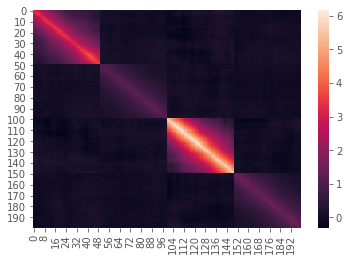

true Sigma
Best MSE we can have (in our dream):  tensor(0.0073)


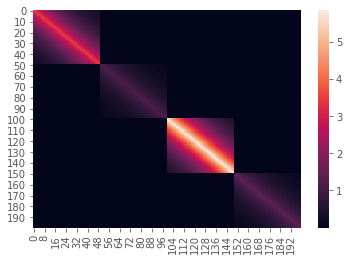

In [33]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z_sampled, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z_sampled.shape[0]*((Z_sampled-mu_MLE).T)@(Z_sampled-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE)
plt.show()
print('true Sigma')
sns.heatmap(true_Sigma)
print('Best MSE we can have (in our dream): ', torch.mean((Sigma_MLE-true_Sigma)**2))

## Generate some Data according to the true parameters

In [9]:
#torch.manual_seed(0)

noise = torch.randn(p) 
Sigma_init =  torch.diag(noise**2)+ 1e-1
#Sigma_init = true_Sigma
C_init = torch.cholesky(Sigma_init)
beta_init = torch.rand((d, p))
#beta_init = true_beta
M_init = torch.randn((n,p))/100# some random values to initialize we divide to avoid nan values 
S_init = torch.randn((n,p))/8 # some random values to initializ. we divise to avoid nan values 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.89539
 MSE with beta :  1.40068
ELBO :  -4816653.00258
Delta :  -4816652.002579216
---------------------------------Maximum number of iterations reached :  20 last delta =  28825.690546681173
 MSE with Sigma :  0.90323
 MSE with beta :  1.40068
 i :  0
beta closed


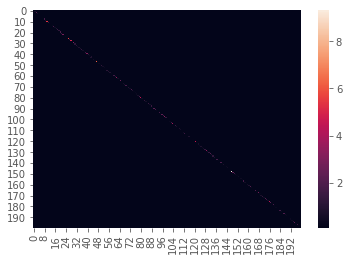

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.90368
 MSE with beta :  1.03586
ELBO :  5946165.96069
Delta :  406285.24464464746


KeyboardInterrupt: 

In [15]:
model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, requires_tridiag = False)
%time model_VEM_beta.VEM_beta_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.001)

## Comparison of models

### We use threadings to go faster.  Allows to lauch all the models at the same time. 

In [17]:
#dict_models_adadelta = launch_models(torch.optim.Adadelta)
dict_models_Rprop = launch_models(torch.optim.Rprop,N_iter = 400, lr = 0.003) 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.89501
 MSE with beta :  1.39695
ELBO :  -4816653.00258
Delta :  -4816652.002579216
iteration number:  200
-------UPDATE-------
 MSE with Sigma :  0.11413
 MSE with beta :  0.17794
ELBO :  37669175.63
Delta :  35.14398796111345
iteration number:  400
-------UPDATE-------
 MSE with Sigma :  0.03646
 MSE with beta :  0.05536
ELBO :  37671509.80727
Delta :  1.477285921573639
iteration number:  600
-------UPDATE-------
 MSE with Sigma :  0.02158
 MSE with beta :  0.03728
ELBO :  37671642.98161
Delta :  0.2970842495560646
iteration number:  800
-------UPDATE-------
 MSE with Sigma :  0.018
 MSE with beta :  0.03139
ELBO :  37671679.00241
Delta :  0.10883677750825882
iteration number:  1000
-------UPDATE-------
 MSE with Sigma :  0.01686
 MSE with beta :  0.0293
ELBO :  37671693.76966
Delta :  0.04923699051141739
iteration number:  1200
-------UPDATE-------
 MSE with Sigma :  0.0164
 MSE with beta :  0.02902
ELBO :  37671700.82137

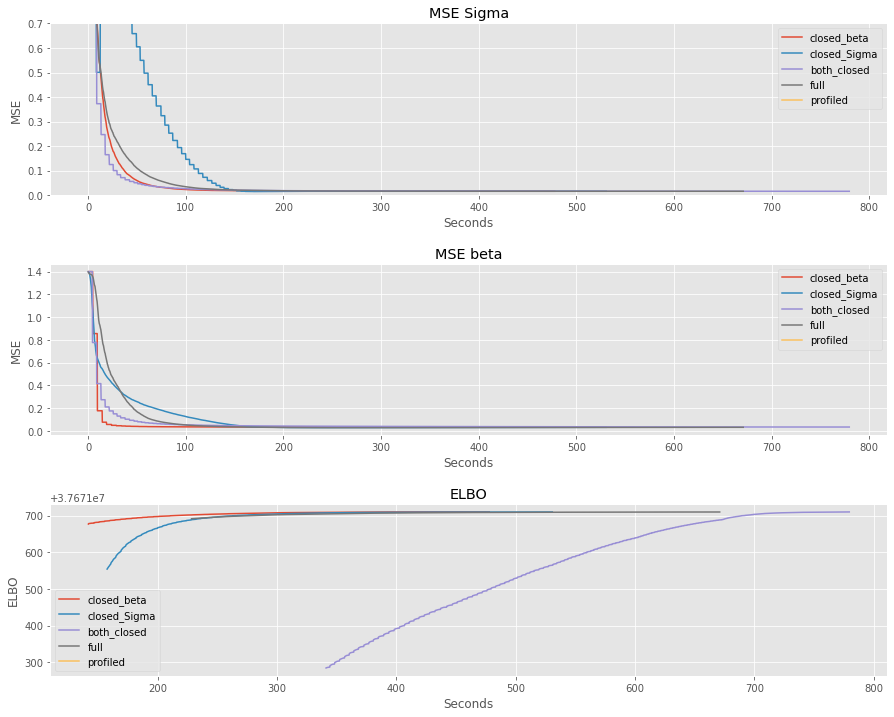

In [37]:
compare_models(dict_models_Rprop)

In [29]:
dict_optimizers = {'Adadelta': torch.optim.Adadelta, 
                   'Adam': torch.optim.Adam, 
                   'Adagrad' : torch.optim.Adagrad,
                   'Adamax' : torch.optim.Adamax,
                  'Rprop' : torch.optim.Rprop, 
                   'RMSprop' : torch.optim.RMSprop}

In [30]:
dict_model_optim = launch_optimizers(dict_optimizers)

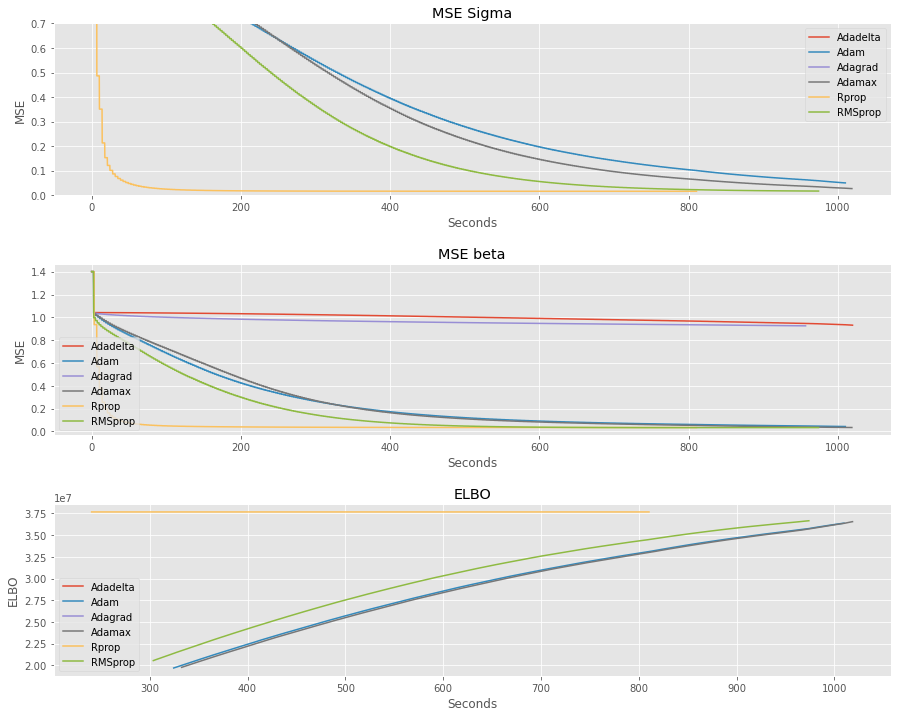

In [35]:
compare_models(dict_model_optim)

model :  closed_beta


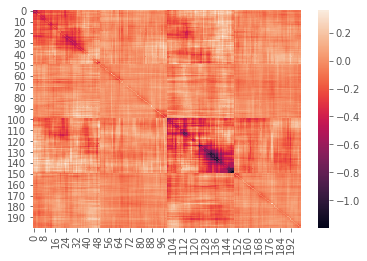

 MSE :  0.01579374251355709
model :  closed_Sigma


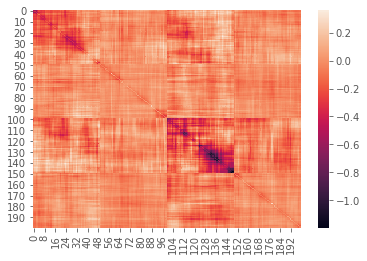

 MSE :  0.0157721134066953
model :  both_closed


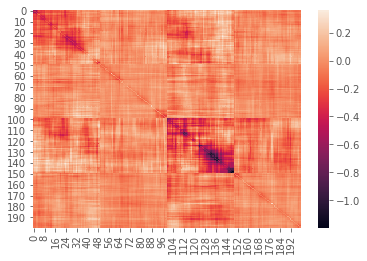

 MSE :  0.015778004410293953
model :  full


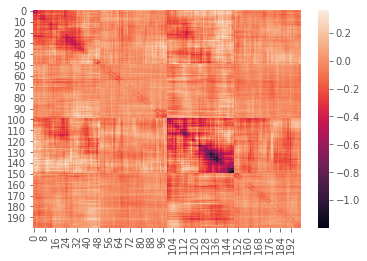

 MSE :  0.015816360753317972
model :  profiled
true Sigma :  AxesSubplot(0.125,0.125;0.62x0.755)


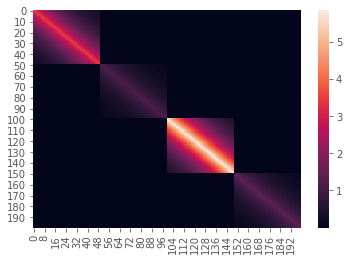

In [26]:
show_Sigma(dict_models_Rprop)

In [42]:
show_Sigma(dict_model_optim)

NameError: name 'dict_model_optim' is not defined

# Parametrisation centered in $X\beta$ and variance $CC^{\top}$

### VEM were we use only the closed form for  $\beta$ 

In [10]:
model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, requires_tridiag = False)
%time model_VEM_beta.VEM_beta_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01163
 MSE with beta :  1.29612
ELBO :  -309838272.86632
Delta :  -309838271.86632276
---------------------------------Maximum number of iterations reached :  20 last delta =  250014.7159500122
 MSE with Sigma :  0.63955
 MSE with beta :  1.29612
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.67232
 MSE with beta :  0.91601
ELBO :  24119301.41534
Delta :  359884.44272771105
---------------------------------Maximum number of iterations reached :  20 last delta =  209740.97836720198
 MSE with Sigma :  1.00556
 MSE with beta :  0.91601
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.01261
 MSE with beta :  0.83031
ELBO :  28506999.37364
Delta :  222703.64052131027
---------------------------------Maximum number of iterations reached :  20 last delta =  201254.24995592982
 MSE with Sigma :  1.07328
 MSE with beta :  0.83031
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.07438
 MSE 

KeyboardInterrupt: 

### Gradient descent on all the parameters

In [17]:
model = PLN_full(C_init, beta_init, M_init, S_init)
%time model.full_grad_ascent(data, N_epoch = 20000,verbose=True, lr = 0.003)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01046
 MSE with beta :  1.29332
ELBO :  -309838272.86632
Delta :  -309838271.86632276
iteration number:  200
-------UPDATE-------
 MSE with Sigma :  0.00773
 MSE with beta :  1.27074
ELBO :  32933394.18762
Delta :  62388.91227066517


KeyboardInterrupt: 

# Parametrisation centered in $X\beta$ and variance $\Sigma$

### VEM were we use only the closed form for  $\Sigma$ 

In [13]:
model_VEM_Sigma = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM_Sigma.VEM_Sigma_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.001)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01056
 MSE with beta :  1.29518
ELBO :  -309838272.86632
Delta :  -309838271.86632276
---------------------------------Maximum number of iterations reached :  20 last delta =  1544552.9421429634
 MSE with Sigma :  0.01056
 MSE with beta :  1.27784
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.04423
 MSE with beta :  1.27703
ELBO :  inf
Delta :  inf
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  1.04423
 MSE with beta :  1.26793
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.9557
 MSE with beta :  1.26759
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.9557
 MSE with beta :  1.26355
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.93862
 MSE with beta :  1.26335
ELBO :  inf
Delta :  nan
---------------------------------Maxi

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.64993
 MSE with beta :  1.18002
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.64993
 MSE with beta :  1.17766
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.64661
 MSE with beta :  1.17753
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.64661
 MSE with beta :  1.1752
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.6437
 MSE with beta :  1.17507
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.6437
 MSE with beta :  1.17275
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.64116
 MSE with beta :  1.17262
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last d

KeyboardInterrupt: 

### VEM were we use the closed form for  $\beta$ and $\Sigma$. Trully a VEM algorithm. 

In [15]:
model_VEM = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM.VEM_both_closed(data,Number_VEM_step =1000, N_epoch_max = 20,verbose=True, lr = 0.001)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01056
 MSE with beta :  1.29612
ELBO :  -309838272.86632
Delta :  -309838271.86632276
---------------------------------Maximum number of iterations reached :  20 last delta =  556072.9780110121
 MSE with Sigma :  0.01056
 MSE with beta :  1.29612
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00694
 MSE with beta :  0.98693
ELBO :  inf
Delta :  inf
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00694
 MSE with beta :  0.98693
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00693
 MSE with beta :  0.97581
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00693
 MSE with beta :  0.97581
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00693
 MSE with beta :  0.9631
ELBO :  inf
Delta :  nan
---------------------------------Maxi

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00594
 MSE with beta :  0.66421
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00594
 MSE with beta :  0.66421
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00586
 MSE with beta :  0.65526
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00586
 MSE with beta :  0.65526
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00577
 MSE with beta :  0.64639
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00577
 MSE with beta :  0.64639
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00568
 MSE with beta :  0.63761
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  18696.003634005785
 MSE with Sigma :  0.00323
 MSE with beta :  0.44699
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00315
 MSE with beta :  0.44053
ELBO :  44997750.06953
Delta :  19120.947120293975
---------------------------------Maximum number of iterations reached :  20 last delta =  18630.96736807376
 MSE with Sigma :  0.00315
 MSE with beta :  0.44053
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00306
 MSE with beta :  0.43415
ELBO :  45371793.23279
Delta :  19036.65187443793
---------------------------------Maximum number of iterations reached :  20 last delta =  18565.438255630434
 MSE with Sigma :  0.00306
 MSE with beta :  0.43415
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00298
 MSE with beta :  0.42786
ELBO :  45744491.15901
Delta :  18952.84745812416
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  16812.945386603475
 MSE with Sigma :  0.00181
 MSE with beta :  0.30088
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0018
 MSE with beta :  0.2965
ELBO :  54607046.24067
Delta :  16957.565444521606
---------------------------------Maximum number of iterations reached :  20 last delta =  16739.256333760917
 MSE with Sigma :  0.0018
 MSE with beta :  0.2965
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00179
 MSE with beta :  0.29218
ELBO :  54942763.48287
Delta :  16879.287726454437
---------------------------------Maximum number of iterations reached :  20 last delta =  16665.332210056484
 MSE with Sigma :  0.00179
 MSE with beta :  0.29218
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00178
 MSE with beta :  0.28792
ELBO :  55276994.92861
Delta :  16800.98441810161
---------------------------------Maximum number of iterations reached :  20 last 

---------------------------------Maximum number of iterations reached :  20 last delta =  14749.65102866292
 MSE with Sigma :  0.00258
 MSE with beta :  0.20309
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00264
 MSE with beta :  0.2002
ELBO :  63138190.24551
Delta :  14818.402461342514
---------------------------------Maximum number of iterations reached :  20 last delta =  14670.704057224095
 MSE with Sigma :  0.00264
 MSE with beta :  0.2002
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00271
 MSE with beta :  0.19735
ELBO :  63432426.30486
Delta :  14737.83216111362
---------------------------------Maximum number of iterations reached :  20 last delta =  14591.611799173057
 MSE with Sigma :  0.00271
 MSE with beta :  0.19735
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00279
 MSE with beta :  0.19455
ELBO :  63725078.4157
Delta :  14657.16623878479
---------------------------------Maximum number of iterations reached :  20 last d

---------------------------------Maximum number of iterations reached :  20 last delta =  12580.332160681486
 MSE with Sigma :  0.00521
 MSE with beta :  0.13945
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00534
 MSE with beta :  0.1376
ELBO :  70520045.73092
Delta :  12618.041955932975
---------------------------------Maximum number of iterations reached :  20 last delta =  12499.098368763924
 MSE with Sigma :  0.00534
 MSE with beta :  0.1376
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00546
 MSE with beta :  0.13578
ELBO :  70770804.95524
Delta :  12536.024524986744
---------------------------------Maximum number of iterations reached :  20 last delta =  12417.851731032133
 MSE with Sigma :  0.00546
 MSE with beta :  0.13578
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00559
 MSE with beta :  0.13399
ELBO :  71019937.7236
Delta :  12454.012680023909
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  10398.975561246276
 MSE with Sigma :  0.00891
 MSE with beta :  0.09908
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00906
 MSE with beta :  0.09792
ELBO :  76721160.25448
Delta :  10420.734905436635
---------------------------------Maximum number of iterations reached :  20 last delta =  10319.376454800367
 MSE with Sigma :  0.00906
 MSE with beta :  0.09792
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0092
 MSE with beta :  0.09677
ELBO :  76928277.63143
Delta :  10340.709943264723
---------------------------------Maximum number of iterations reached :  20 last delta =  10239.917095348239
 MSE with Sigma :  0.0092
 MSE with beta :  0.09677
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00935
 MSE with beta :  0.09565
ELBO :  77133803.72569
Delta :  10260.833939790726
---------------------------------Maximum number of iterations reached :  20 la

---------------------------------Maximum number of iterations reached :  20 last delta =  8314.500074073672
 MSE with Sigma :  0.0128
 MSE with beta :  0.07364
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01294
 MSE with beta :  0.0729
ELBO :  81765087.68349
Delta :  8327.471263766289
---------------------------------Maximum number of iterations reached :  20 last delta =  8240.520554706454
 MSE with Sigma :  0.01294
 MSE with beta :  0.0729
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01308
 MSE with beta :  0.07218
ELBO :  81930561.12048
Delta :  8253.255014300346
---------------------------------Maximum number of iterations reached :  20 last delta =  8166.817537277937
 MSE with Sigma :  0.01308
 MSE with beta :  0.07218
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01322
 MSE with beta :  0.07146
ELBO :  82094557.61923
Delta :  8179.320344910026
---------------------------------Maximum number of iterations reached :  20 last delt

KeyboardInterrupt: 

# Parametrisation centered in $0$ and variance $I$


## Gradient descent with the PCA formula

In [16]:
model_PCA = PLN_full(C_init, beta_init, M_init, S_init)
%time model_PCA.full_grad_ascent_PCA(data, N_epoch = 15000,verbose=True, lr = 0.003)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01053
 MSE with beta :  1.29326
ELBO :  38207873.25626
Delta :  38207874.25626229
iteration number:  200
-------UPDATE-------
 MSE with Sigma :  1.07048
 MSE with beta :  0.98914
ELBO :  91431435.59078
Delta :  22092.50705073774
iteration number:  400
-------UPDATE-------
 MSE with Sigma :  1.25593
 MSE with beta :  0.93859
ELBO :  93188984.0805
Delta :  3723.9533174932003
iteration number:  600
-------UPDATE-------
 MSE with Sigma :  1.14124
 MSE with beta :  0.90828
ELBO :  93714261.17841
Delta :  1902.9233811944723


KeyboardInterrupt: 

# Parametrisation centered in 0 and variance Sigma

## VEM of the first notebook  

In [110]:
model_first_VEM = PLN_full(C_init, beta_init, M_init, S_init)
%time model_first_VEM.first_VEM(data,Number_VEM_step =1000, N_epoch_max = 20,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01683
 MSE with beta :  1.42789
ELBO :  672886.44394
Delta :  672887.4439430049
---------------------------------Maximum number of iterations reached :  20 last delta =  11896.76700986165
 MSE with Sigma :  0.01683
 MSE with beta :  1.25778
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00951
 MSE with beta :  1.25034
ELBO :  1050317.52274
Delta :  36659.96190730354
---------------------------------Maximum number of iterations reached :  20 last delta =  8044.187936921371
 MSE with Sigma :  0.00951
 MSE with beta :  1.13807
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00909
 MSE with beta :  1.13359
ELBO :  1241185.8703
Delta :  11225.136133969761
---------------------------------Maximum number of iterations reached :  20 last delta =  6164.436613778584
 MSE with Sigma :  0.00909
 MSE with beta :  1.06656
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01079
 MSE with beta : 

---------------------------------Maximum number of iterations reached :  20 last delta =  8.170653669163585
 MSE with Sigma :  1.33549
 MSE with beta :  0.78748
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.35009
 MSE with beta :  0.78716
ELBO :  1918961.88897
Delta :  18.356055904645473
---------------------------------Maximum number of iterations reached :  20 last delta =  7.078475828049704
 MSE with Sigma :  1.35009
 MSE with beta :  0.78112
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.3634
 MSE with beta :  0.78082
ELBO :  1919130.58844
Delta :  16.367620446253568
---------------------------------Maximum number of iterations reached :  20 last delta =  6.1965171347837895
 MSE with Sigma :  1.3634
 MSE with beta :  0.77508
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.37562
 MSE with beta :  0.77479
ELBO :  1919278.31598
Delta :  14.721906178398058
---------------------------------Maximum number of iterations reached :  20 last de

---------------------------------Maximum number of iterations reached :  20 last delta =  0.7625093006063253
 MSE with Sigma :  1.52543
 MSE with beta :  0.67446
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.52849
 MSE with beta :  0.67432
ELBO :  1920640.05221
Delta :  3.179100699722767
---------------------------------Maximum number of iterations reached :  20 last delta =  0.7278292661067098
 MSE with Sigma :  1.52849
 MSE with beta :  0.67172
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.53143
 MSE with beta :  0.67158
ELBO :  1920659.32022
Delta :  3.030372940003872
---------------------------------Maximum number of iterations reached :  20 last delta =  0.6978288462851197
 MSE with Sigma :  1.53143
 MSE with beta :  0.66902
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.53426
 MSE with beta :  0.66889
ELBO :  1920677.75897
Delta :  2.8915474952664226
---------------------------------Maximum number of iterations reached :  20 last 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.3806735915131867
 MSE with Sigma :  1.58292
 MSE with beta :  0.60881
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58413
 MSE with beta :  0.60871
ELBO :  1921011.47566
Delta :  1.2840719004161656
---------------------------------Maximum number of iterations reached :  20 last delta =  0.37634967849589884
 MSE with Sigma :  1.58413
 MSE with beta :  0.60692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.5853
 MSE with beta :  0.60683
ELBO :  1921020.75585
Delta :  1.2636519484221935
---------------------------------Maximum number of iterations reached :  20 last delta =  0.37155090109445155
 MSE with Sigma :  1.5853
 MSE with beta :  0.60506
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58643
 MSE with beta :  0.60496
ELBO :  1921029.92603
Delta :  1.243976149475202
---------------------------------Maximum number of iterations reached :  20 last

---------------------------------Maximum number of iterations reached :  20 last delta =  0.3003910242114216
 MSE with Sigma :  1.60429
 MSE with beta :  0.5621
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60462
 MSE with beta :  0.56202
ELBO :  1921239.9342
Delta :  0.9063316590618342
---------------------------------Maximum number of iterations reached :  20 last delta =  0.2971813522744924
 MSE with Sigma :  1.60462
 MSE with beta :  0.56064
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60492
 MSE with beta :  0.56056
ELBO :  1921247.07593
Delta :  0.8937568210531026
---------------------------------Maximum number of iterations reached :  20 last delta =  0.29459326388314366
 MSE with Sigma :  1.60492
 MSE with beta :  0.55919
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60519
 MSE with beta :  0.55911
ELBO :  1921254.1423
Delta :  0.8840063863899559
---------------------------------Maximum number of iterations reached :  20 last 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.22332628699950874
 MSE with Sigma :  1.60456
 MSE with beta :  0.52616
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60428
 MSE with beta :  0.5261
ELBO :  1921407.31712
Delta :  0.6284733857028186
---------------------------------Maximum number of iterations reached :  20 last delta =  0.21362532046623528
 MSE with Sigma :  1.60428
 MSE with beta :  0.52494
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60397
 MSE with beta :  0.52487
ELBO :  1921412.42443
Delta :  0.5926260051783174
---------------------------------Maximum number of iterations reached :  20 last delta =  0.21741046058014035
 MSE with Sigma :  1.60397
 MSE with beta :  0.52371
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60365
 MSE with beta :  0.52365
ELBO :  1921417.58829
Delta :  0.6068854329641908
---------------------------------Maximum number of iterations reached :  20 l

---------------------------------Maximum number of iterations reached :  20 last delta =  0.15547523368149996
 MSE with Sigma :  1.58983
 MSE with beta :  0.49401
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58896
 MSE with beta :  0.49395
ELBO :  1921525.15542
Delta :  0.4356669296976179
---------------------------------Maximum number of iterations reached :  20 last delta =  0.15545910014770925
 MSE with Sigma :  1.58896
 MSE with beta :  0.49284
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58806
 MSE with beta :  0.49278
ELBO :  1921528.77861
Delta :  0.43237787764519453
---------------------------------Maximum number of iterations reached :  20 last delta =  0.15118601243011653
 MSE with Sigma :  1.58806
 MSE with beta :  0.49167
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58713
 MSE with beta :  0.49161
ELBO :  1921532.34948
Delta :  0.4248384772799909
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.11711207055486739
 MSE with Sigma :  1.55387
 MSE with beta :  0.46264
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.55195
 MSE with beta :  0.46258
ELBO :  1921609.78586
Delta :  0.33542190422303975
---------------------------------Maximum number of iterations reached :  20 last delta =  0.11526696430519223
 MSE with Sigma :  1.55195
 MSE with beta :  0.46149
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.54998
 MSE with beta :  0.46143
ELBO :  1921612.46104
Delta :  0.3337338676210493
---------------------------------Maximum number of iterations reached :  20 last delta =  0.11115376721136272
 MSE with Sigma :  1.54998
 MSE with beta :  0.46034
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.54796
 MSE with beta :  0.46028
ELBO :  1921615.12449
Delta :  0.3272165155503899
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.08871011203154922
 MSE with Sigma :  1.48301
 MSE with beta :  0.43188
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.47956
 MSE with beta :  0.43182
ELBO :  1921673.8567
Delta :  0.26242438657209277
---------------------------------Maximum number of iterations reached :  20 last delta =  0.08713338896632195
 MSE with Sigma :  1.47956
 MSE with beta :  0.43075
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.47605
 MSE with beta :  0.43069
ELBO :  1921675.92893
Delta :  0.2586842691525817
---------------------------------Maximum number of iterations reached :  20 last delta =  0.08755948557518423
 MSE with Sigma :  1.47605
 MSE with beta :  0.42962
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.47247
 MSE with beta :  0.42956
ELBO :  1921677.97871
Delta :  0.25666661467403173
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.06895425007678568
 MSE with Sigma :  1.36632
 MSE with beta :  0.4014
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.36102
 MSE with beta :  0.40135
ELBO :  1921723.40643
Delta :  0.19757895357906818
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06107461708597839
 MSE with Sigma :  1.36102
 MSE with beta :  0.40027
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.35564
 MSE with beta :  0.40021
ELBO :  1921724.99653
Delta :  0.19185819057747722
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06784511171281338
 MSE with Sigma :  1.35564
 MSE with beta :  0.39914
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.3502
 MSE with beta :  0.39908
ELBO :  1921726.60332
Delta :  0.19471151544712484


KeyboardInterrupt: 

Here we have a PLN model described as the following : 

- Consider $n$ sites $(i=1 \ldots n)$

- Measure $x_{i}=\left(x_{i h}\right)_{1 \leq h \leq d}$ :
$x_{i h}=$ given environmental descriptor (covariate) for site $i$
(altitude, temperature, latitude, ...)

- Consider $p$ species $(j=1 \ldots p)$ Measure $Y=\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ :

- Measure $Y = Y_{i j}=$ number of observed individuals from species $j$ in site $i$ (abundance). 

- Associate a random vector $Z_{i}$ with each site Assume that the unknown $\left(Z_{i}\right)_{1 \leq i \leq n}$ are independant such that:
$$
Z_{i} \sim \mathcal{N}_{p}(x_i \beta, \Sigma) \quad \Sigma = CC^{\top}
$$

and $C$ is a lower triangular matrix. 
- Assume that the observed abundances $\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ are independent conditionally on the $Z=\left(Z_{i}\right)_{i}$


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
$$

Where $O = (o_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ are known offsets. 

The unknown parameter is $\theta = (C,\beta)$.

$Z$ being a latent variable, we want to use the EM algorithm to derive the maximum likelihood estimator. However, it requires to compute 

$$
\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y\right)\right]=\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y_{i}\right)\right] \propto \int_{\mathbb{R}^{p}} p_{\theta}\left(Z_{i}\right) \prod_{j} p_{\theta}\left(Y_{i j} \mid Z_{i j}\right) \mathrm{d} Z_{i}
$$ which is intractable in practice. 

We thus choose the variationnal approximation. We set

$$ 
q^{\star} = \underset{q \in \mathcal{Q_{gauss}}}{\operatorname{argmax}} J_{\theta,q}(Y) 
$$
<br>
$$
\begin{align} J_{\theta, q}(Y)& =\log p_{\theta}(Y)-K L\left[q(Z) \| p_{\theta}(Z \mid Y)\right]                                    \\ 
                              & = \mathbb{E}_{q}\left[\log p_{\theta}(Y, Z)\right] \underbrace{-\mathbb{E}_{q}[\log q(Z)]}_{\text {entropy } \mathcal{H}(q)}    \end{align}
$$

where 

$$
\mathcal{Q}_{\text {Gauss }}=\{
q=\left(q_{1}, \ldots q_{n}\right), q_{i} \sim \mathcal{N}\left(M_{i}, \operatorname{diag} (S_{i}\odot S_i ), M_i \in \mathbb{S} ^p, S_i \in \mathbb{R} ^p\right)\}
$$


The Variational EM (VEM) consists in alternate between two steps : 
- VE step: update $q$
$$
q^{h+1}=\underset{q \in \mathcal{Q_{gauss}}}{\arg \max } J_{\theta^{h}, q}(Y)=\underset{q \in \mathcal{Q_{gauss}}}{\arg \min } K L\left[q(Z) \| p_{\theta^{h}}(Z \mid Y)\right]
$$
- M step: update $\theta$
$$
\theta^{h+1}=\underset{\theta}{\arg \max } J_{\theta, q^{h+1}}(Y)=\underset{\theta}{\arg \max } \mathbb{E}_{q^{h+1}}\left[\log p_{\theta}(Y, Z)\right]
$$

Let's compute the ELBO $J_{\theta, q}(Y)$


$$
J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_{i}\right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i j}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+Z_{i j}\right)-\exp \left(o_{i j}+Z_{i j}\right)\right] + cst
\end{align}
$$

We need to compute some moments of $Z$ under $q$. 

$$
\mathbb{E}_{q}\left[Z_{i j}\right]=M_{i j} \quad \quad E_{q}\left[\operatorname{exp}\left(Z_{i j}\right)\right]=\frac{1}{2} \operatorname{exp}\left(M_{i j}+\frac{(S_{ij})^2}{2}\right)
$$

So that 

$$
\begin{aligned}
(1) &=\sum_{i, j} Y_{i j}\left(o_{i j}+M_{i j}\right)-\frac{1}{2} \exp \left(o_{i j}+M_{i j}+\frac{(S_{i_{jj}})^2}{2}\right) + cst \\
&=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S \odot S}{2}\right)\right)\mathbb{1}_p + cst 
\end{aligned}
$$



Where we have denoted $M = (M_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ and $ S = (S_{ij})_{1\leq i\leq n, 1\leq j\leq p}$. The exponential is applied pointwise on the last equation. 

$$
\begin{aligned}
(3)=H(q) &=\sum_{i} H\left(q_{i}\right) \\
&=\sum_{i} \log \left(\sqrt{(2 \pi e)^{p}\left|S_{i}\right|}\right) \\
&=\frac 12\sum_{i} \log (S_{i} \odot S_i)^2 +cst \\
&= \frac 12 \sum_{i j} \log S_{i j}^2+cst \\
& = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst\\
\end{aligned}
$$

Where the log is applied pointwise at the last equation. 

$$
\begin{aligned}
(2)=\mathbb{E}_{q}\left[\log p_{\theta}(Z)\right] &=\sum_{1} E_{q}\left[\log p_{\theta}\left(Z_{i}\right)\right] \\
&=-\frac{n}{2} \log |\Sigma|+\sum_{i} \mathbb{E}_{q}\left[-\frac{1}{2}\left(Z_{i}-X_{i} \beta\right)^{\top} \Sigma^{-1}\left(Z_{i} - X_{i} \beta\right)\right] +cst
\end{aligned}
$$

$
\text { Let } V \sim \mathcal{N} \left(\mu, \Lambda), \mu \in \mathbb{R}^{p}, \Lambda \in \mathcal S _p ^{++}\right.  \\
\text { Let's compute } \; \mathbb{E}\left[V^{\top} \Sigma^{-1} V\right]
$

We denote $\Sigma ^{-1 / 2}$ the square root Matrix of $\Sigma^{-1}$. It exists since $\Sigma ^{-1} \in \mathcal{S}_p^{++}$. 

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\left[V^{\top}\Sigma ^{-1 / 2} \Sigma^{-1 / 2} V\right]\\
&=\mathbb{E}\left[\left(\Sigma^{-1 / 2} V\right)^{\top}\left(\Sigma^{-1 / 2} V\right)\right] \\
&=\mathbb{E} \|\Sigma^{-1 / 2} V \|_{2}^{2}
\end{aligned}
$$

$
\text {Let } \tilde{V}=\Sigma^{-1 / 2} V, \quad \tilde{V} \sim \mathcal{N}\left(\Sigma^{-1 / 2} \mu,  \Sigma^{-1 / 2} \Lambda \Sigma^{-\frac{1}{2}}\right)
$

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\|\widetilde{V}\|_{2}^{2} \\
&=\sum \mathbb E \widetilde{V}_{j}^{2} \\
&=\sum \operatorname{var}\left(\widetilde{V}_{j}\right)^{2}+\mathbb{E}\left[\widetilde{V}_{j}\right]^{2}\\
&=\sum_{j}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)_{j j}+\left(\Sigma^{-1 / 2} \mu\right)^{2}_j\\
&= \operatorname{tr}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1 / 2}\right)^{\top} \mu\right)^{2}\\
&=\operatorname{tr}\left(\Sigma^{-1} \Lambda\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1/2}\right)^{\top} \mu\right)^2
\end{aligned}
$$

Since under $q$, $Z_{i}-X_{i} \beta \sim \mathcal N (M_i - X_i \beta, S_i \odot S_i ) $
$$
\begin{equation}
\begin{aligned}
(2) &=- \frac 12 \sum_{i} \operatorname{tr}\left(\Sigma^{-1} (S_{i} \odot S_i) \right) - \frac 12 \sum_{i, j}\left(\left(\Sigma_{j,.}^{-1 / 2} \right) ^{\top}\left(M_{i}-X_{i} \beta\right)\right)^2  - \frac n2 \log |\Sigma|+ cst  \\
&= - \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i}\odot S_i \right)\right) - \frac 12 \sum_{i, j}\left(\Sigma^{-1 / 2}(M-X \beta)\right)_{j, i}^{\top}\left(\Sigma
^{-1 / 2}(M-X \beta)\right)_{i, j}  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i} \odot S_i  \right)\right)- \frac 12 \operatorname{tr}\left(\Sigma^{-1 / 2}(M-X \beta)^{\top}(M-X \beta) \Sigma^{-1 / 2}\right)  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right)  - \frac n2 \log |\Sigma|+ cst 
\end{aligned}
\end{equation}
$$
We then have : 

PARAMETRISATION CENTERED IN $X\beta$ and variance $\Sigma$


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$



If we use $C$ instead of $\Sigma$ : 


PARAMETRISATION CENTERED IN $X\beta$ and variance $CC^{\top}$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

We consider the same setting but another parametrization of the model : 

$$
\begin{array}{l}
Z_{i} \sim \mathcal N_{p}\left(0, I_{p}\right) \\
Y_{i j} \mid Z_{i} \sim \mathcal P \left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right)
\end{array}
$$
Writing in Matrix form : 

$$
Y \mid Z \sim \mathcal P\left(\exp \left(O+X \beta+ ZC\right)\right)
$$

This parametrization asks less things to the Variational part. 

Let's compute the ELBO $\tilde J_{\theta, q}(Y)$ of this new parametrisation. 


$$
\tilde J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_i \right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+x_{i}^{\top} \beta_{j}+ C_{j}^{\top} Z_i\right)-\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right] + cst
\end{align}
$$

Let $1\leq i \leq n, 1 \leq j \leq p$. Let's compute $\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right]$


$$
\begin{aligned}
\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right] &=\mathbb{E}_{q}\left[\exp \left(\sum_{k=1}^{p} C_{j k}Z_{ik}\right)\right] \\
&=\mathbb{E}_{q}\left[\prod_{k=1}^{p} \exp \left(C_{j k} Z_{i k}\right)\right] \\
&=\prod_{k=1}^p\mathbb{E}_{q} \left[\exp \left(C_{j k} Z_{i k}\right)\right] \\ 
&=\prod_{k=1}^{p} exp \left(M_{i_{k}} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&= \exp \left(\sum_{k=1}^{p} M_{i k} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&=\exp \left(M_{i}^{\top} C_{j}+\frac{\left(S_{i}^{2}\right)^{T} C_{j}^2}{2}\right)
\end{aligned}
$$

Ainsi, 

$$
(1)=1_{n}^{\top}\left(Y \odot (O+X \beta+MC) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{  (S \odot S)(C\odot C) }{2}\right)\right)1_{p}
$$

For $(2)$, we take $X\beta = 0, \Sigma = I_p$ in $(2)$ from the previous parametrisation to get : 
$$
(2) = - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right)  - \frac {n}2 \log 1 + cst 
$$

For $(3)$, we have a similar argument as in $(3)$ from previous parametrisation to get : 

$$(3) = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst$$

We then get : 

PARAMETRISATION CENTERED IN 0 AND UNIT VARIANCE 

$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+C M) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{(C\odot C)   (S \odot S)}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$

We can have a last parametrization that is : 

$$
Z_{i} \sim \mathcal{N}_{p}(0, \Sigma)
$$

and 


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)\right)
$$

This model is equivalent to the other ones but the variational step is different. 

PARAMETRISATION CENTERED IN 0 AND VARIANCE $\Sigma$

$$
\boxed{
\begin{aligned}
J_{\theta, q}(y) &=-\frac{n}{2} \log |\Sigma|-\frac{1}{2} \sum_{i} m_{i}^{\top} \Sigma^{-1} m_{i}+tr\left(\Sigma^{-1} S_{i}\right) \\
&+\sum_{i, j}-\exp \left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}+\left[S_{i}\right]_{j j}^{2} / 2\right)+Y_{i j}\left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}\right) \\
&+\frac{1}{2} \sum_{i} \log \left|(S\odot S)_{i}\right|+c s t .
\end{aligned}}
$$
    

In [170]:
def f(x) : 
    return x**2

x = torch.tensor([8.])
x.requires_grad_(True)
test_optim = torch.optim.SGD([x], lr = 2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(test_optim, factor = 0.5, patience = 1)

for i in range(100): 
    
    print('normalement : ',x-2*test_optim.param_groups[0]['lr']*x)
    loss = f(x)
    loss.backward()
    test_optim.step()
    scheduler.step(loss.item())
    test_optim.zero_grad()
    print('lr : ', test_optim.param_groups[0]['lr'])
    print('x : ', x )

normalement :  tensor([-24.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([-24.], requires_grad=True)
normalement :  tensor([72.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([72.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([216.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], 